#### 1. Install dependencies

In [1]:
from mss import mss # for grabbing a screen shot of a monitor
#import pydirectinput # for mouse and keyboard input on windows
import pyautogui # for mouse and keyboard input for multiplatform
import cv2 # for image and video processing
import numpy as np 
import pytesseract # OCR tool for reading text from images
from matplotlib import pyplot as plt
import time 
from gymnasium import Env
from gymnasium.spaces import Box, Discrete # class structures to implement observation and action spaces
from gymnasium.utils import env_checker  # Import the environment checker
from collections import deque

In [4]:
print(pytesseract.__version__)
print(pyautogui.__version__)


0.3.13
0.9.54


#### 2. Create Environment

In [146]:
class DinoGame(Env):
    def __init__(self):
        
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(1,50,100), dtype=np.uint8)
        self.action_space = Discrete(3) # number of possible actions
        self.cap = mss()
        self.game_location = {'top':780, 'left':-2560, 'width':700, 'height':300} # defines viewing area
        self.done_location = {'top':550, 'left':-1730, 'width':900, 'height':120} # defines 'GAME OVER' location    
   
    # method to take an action as an input and applies it to the environment
    def step(self, action):
        action_map = {
            0:'space', # Jump
            1:'down', # Duck
            2:'no_op' # No action
        }

        total_reward = 0
        # Perform the action
        if action != 2:
            pyautogui.press(action_map[action])
        # Checking whether the game is done/terminated
        done = self.get_done()

        # Reward - we get a point for every frame we are alive
        reward = 1
        if done:
            reward = -100
        total_reward += reward

        truncated = False  # Add logic here if need to end the episode early

        # Get the next observation
        new_observation = self.get_observation()
        
        # Info dictionary
        info = {} # needed for stablebaselines what it expects
        
        return new_observation, total_reward, done, truncated, info
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Resets the environment to its initial state
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        time.sleep(1)
        pyautogui.click(x=-1385, y=527)
        pyautogui.press('space')
        return self.get_observation(), {}
    
    def close(self):
        cv2.destroyAllWindows()
    
    # observation of the state of the environment
    def get_observation(self):
        # Get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        #Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (100,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,100))
        return channel
    
    # Get the done text using OCR
    def get_done(self):
        # Get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        
        # Apply OCR
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res == 'GAME': # NOTE: doesn't recognize 'OVER'
            done = True
        return done
    

In [86]:
import pyautogui
import time

print("Move your mouse to the desired position and wait 5 seconds...")
time.sleep(5)
x, y = pyautogui.position()
print(f"Mouse position: x={x}, y={y}")


Move your mouse to the desired position and wait 5 seconds...
Mouse position: x=-2358, y=925


In [147]:
env = DinoGame()

GAME


True

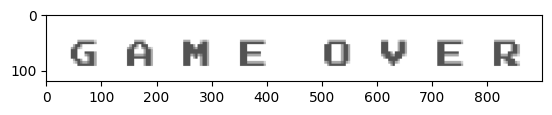

In [106]:
done, res, done_cap = env.get_done()
plt.imshow(done_cap)
print(res)
done

In [80]:
env.reset()

(array([[[255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         ...,
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255],
         [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8),
 {})

In [137]:
env.render()

In [138]:
env.close()

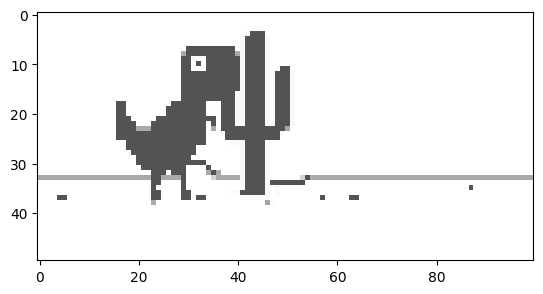

In [136]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

### 3. Testing the Environment

In [143]:
# Play 3 games
for episode in range(3):
    obs = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        obs, reward, done, _, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')

Total Reward for episode 0 is -73
Total Reward for episode 1 is -55
Total Reward for episode 2 is -74
Total Reward for episode 3 is -68
Total Reward for episode 4 is -74
Total Reward for episode 5 is -73
Total Reward for episode 6 is -75
Total Reward for episode 7 is -75
Total Reward for episode 8 is -74
Total Reward for episode 9 is -35


### 4. Training NN

In [144]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [148]:
# validates the custom environment and ensures it complies with the interface and conventions
env_checker.check_env(env)

In [150]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [151]:
CHECKPOINT_DIR = './DinoGame/train/'
LOG_DIR = './DinoGame/logs'

In [152]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [106]:
from stable_baselines3 import DQN


In [107]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\ProgramData\Anaconda3\CondaEnvs\.conda\dinoRL\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 28.82GB > 19.10GB
  warnings.warn(


In [108]:
model.learn(total_timesteps=5000, callback=callback)

Logging to ./logs\DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.5      |
|    ep_rew_mean      | -97.5    |
|    exploration_rate | 0.973    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 24       |
|    total_timesteps  | 14       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.62     |
|    ep_rew_mean      | -97.4    |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 0        |
|    time_elapsed     | 48       |
|    total_timesteps  | 29       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.58     |
|    ep_rew_mean      | -97.4    |
|    exploration_rate | 0.918    |
| time/               |        

KeyboardInterrupt: 

In [74]:
model.load(os.path.join('train', 'best_model_5000'))

c:\ProgramData\Anaconda3\CondaEnvs\.conda\dinoRL\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 13.69GB
  warnings.warn(


In [76]:
for episode in range(10):
    obs, _ = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)

Total Reward for episode 0 is 12
Total Reward for episode 1 is 10


KeyboardInterrupt: 